In [24]:
# acs = [1,0]
# fcs = [1,0]
# pcs = [1,0]
# smalls = [1]
batch_nums = list(range(3))

# MUST BE SET
ac = 1
fc = 1
pc = 1
small = 1


train = "train"


# MUST BE SET, doesn't need to change
num_vals = 160
num_cores = 80
num_run_throughs = 4
num_params = 6


# MUST BE SET
out_base = "/n/murphy_lab/lab/isaac_bigtest/"
data_loc = "~/HS_data/"

dep = ""
dep = " --dependency=afterok:%d"%44021844



for batch_num in batch_nums:
    print('sbatch --export=script=gen_yamls.py,args="%s %d %d %d %d %d" script_gen_yamls.slurm'%(train, ac,fc,pc,small,batch_num))
    
print('\n')
for batch_num in batch_nums:
    print('sbatch --export=removal_dir="yamls_train%d%d%d%d%d" script_removal.slurm'%(ac,fc,pc,small,batch_num))
    print("\n")
    print('sbatch --export=removal_dir="%s*%d%d%d%d%d" script_removal.slurm'%(out_base, ac,fc,pc,small,batch_num))
    print("\n")

for batch_num in batch_nums:
    # Run iter_test (runner)
    identifier = "%s%d%d%d%d%d"%(train, ac,fc,pc,small,batch_num)
    print(('sbatch%s --export=num_vals=%d,yaml_loc="yamls_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/",result_dir="results_' + identifier + '/" script_iter_train.slurm')%(dep,num_vals))
    print("\n")

    # Run iter_exec batch
    print(('sbatch%s --array=0-%d --export=num_vals=%d,tot_runs=%d,yaml_loc="yamls_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/",data_loc="' + data_loc +'" script_iter_exec.slurm') % (dep,num_cores-1,num_vals,num_run_throughs*num_params))
    print("\n")


sbatch --export=script=gen_yamls.py,args="train 1 1 1 1 0" script_gen_yamls.slurm
sbatch --export=script=gen_yamls.py,args="train 1 1 1 1 1" script_gen_yamls.slurm
sbatch --export=script=gen_yamls.py,args="train 1 1 1 1 2" script_gen_yamls.slurm


sbatch --export=removal_dir="yamls_train11110" script_removal.slurm


sbatch --export=removal_dir="/n/murphy_lab/lab/isaac_bigtest/*11110" script_removal.slurm


sbatch --export=removal_dir="yamls_train11111" script_removal.slurm


sbatch --export=removal_dir="/n/murphy_lab/lab/isaac_bigtest/*11111" script_removal.slurm


sbatch --export=removal_dir="yamls_train11112" script_removal.slurm


sbatch --export=removal_dir="/n/murphy_lab/lab/isaac_bigtest/*11112" script_removal.slurm


sbatch --dependency=afterok:44021844 --export=num_vals=160,yaml_loc="yamls_train11110/",out_dir="/n/murphy_lab/lab/isaac_bigtest/results_train11110/",fig_dir="/n/murphy_lab/lab/isaac_bigtest/resultsfig_train11110/",result_dir="results_train11110/" script_iter_train.

In [ ]:
gen_y

In [141]:
ac = 0
fc = 1
pc = 1
small = 0
train = "train"
batch_num = 0
num_vals = 160
num_cores = 80
num_run_throughs = 4
num_params = 6

out_base = "/n/murphy_lab/lab/isaac_bigtest_std/"

dep = ""
dep = " --dependency=afterok:%d"%40623875
# dep = " --begin=now+1800"

# val = new_vals[4]
val = "1110"

# test_num = "2"
test_num=""
p = ps[1]

for batch_num in batch_nums:
    
    identifier = "%s%s%d_%d"%(train, val,batch_num,p)
    print(('sbatch%s --export=num_vals=%d,yaml_loc="yamls' + test_num + '_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/",result_dir="results' + test_num + '_' + identifier + '/",cutoff=' + str(p) + ' script_iter_train_std.slurm')%(dep,num_vals))
    print("\n")

    # Run iter_exec batch
    print(('sbatch%s --array=0-%d --export=num_vals=%d,tot_runs=%d,yaml_loc="yamls' + test_num + '_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/" script_iter_exec.slurm') % (dep,num_cores-1,num_vals,num_run_throughs*num_params))
    print("\n")
    
print("\n")

sbatch --dependency=afterok:40623875 --export=num_vals=160,yaml_loc="yamls_train11100_50/",out_dir="/n/murphy_lab/lab/isaac_bigtest_std/results_train11100_50/",fig_dir="/n/murphy_lab/lab/isaac_bigtest_std/resultsfig_train11100_50/",result_dir="results_train11100_50/",cutoff=50 script_iter_train_std.slurm


sbatch --dependency=afterok:40623875 --array=0-79 --export=num_vals=160,tot_runs=24,yaml_loc="yamls_train11100_50/",out_dir="/n/murphy_lab/lab/isaac_bigtest_std/results_train11100_50/",fig_dir="/n/murphy_lab/lab/isaac_bigtest_std/resultsfig_train11100_50/" script_iter_exec.slurm


sbatch --dependency=afterok:40623875 --export=num_vals=160,yaml_loc="yamls_train11101_50/",out_dir="/n/murphy_lab/lab/isaac_bigtest_std/results_train11101_50/",fig_dir="/n/murphy_lab/lab/isaac_bigtest_std/resultsfig_train11101_50/",result_dir="results_train11101_50/",cutoff=50 script_iter_train_std.slurm


sbatch --dependency=afterok:40623875 --array=0-79 --export=num_vals=160,tot_runs=24,yaml_loc="yamls_tr

In [16]:
ac = 0
fc = 1
pc = 1
small = 0
train = "train"
batch_num = 0
num_vals = 160
num_cores = 80
num_run_throughs = 4
num_params = 6

out_base = "/n/murphy_lab/lab/isaac_bigtest/"

dep = ""
# dep = " --dependency=afterok:%d"%40070427

# val = new_vals[4]
val = "1110"

# test_num = "2"
test_num=""
vals= ["1110","1111","1100","1010","0110"]
new_vals= ["0000","1000","0100","0010","0001"]
for val in vals+new_vals:
    for batch_num in batch_nums:
        identifier = "%s%s%d"%(train, val,batch_num)
        print(('sbatch%s --export=num_vals=%d,yaml_loc="yamls' + test_num + '_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/",result_dir="results' + test_num + '_' + identifier + '/" ' + 'script_iter_train_comptest.slurm')%(dep,num_vals))
        print("\n")

print("\n")

sbatch --export=num_vals=160,yaml_loc="yamls_train11100/",out_dir="/n/murphy_lab/lab/isaac_bigtest/results_train11100/",fig_dir="/n/murphy_lab/lab/isaac_bigtest/resultsfig_train11100/",result_dir="results_train11100/" script_iter_train_comptest.slurm


sbatch --export=num_vals=160,yaml_loc="yamls_train11101/",out_dir="/n/murphy_lab/lab/isaac_bigtest/results_train11101/",fig_dir="/n/murphy_lab/lab/isaac_bigtest/resultsfig_train11101/",result_dir="results_train11101/" script_iter_train_comptest.slurm


sbatch --export=num_vals=160,yaml_loc="yamls_train11102/",out_dir="/n/murphy_lab/lab/isaac_bigtest/results_train11102/",fig_dir="/n/murphy_lab/lab/isaac_bigtest/resultsfig_train11102/",result_dir="results_train11102/" script_iter_train_comptest.slurm


sbatch --export=num_vals=160,yaml_loc="yamls_train11110/",out_dir="/n/murphy_lab/lab/isaac_bigtest/results_train11110/",fig_dir="/n/murphy_lab/lab/isaac_bigtest/resultsfig_train11110/",result_dir="results_train11110/" script_iter_train_compt

In [67]:
vals

['1110', '1111', '1100', '1010', '0110']

In [82]:
new_vals= ["0000","1000","0100","0010","0001"]

['0101',
 '1000',
 '0011',
 '0010',
 '1001',
 '0000',
 '1101',
 '0111',
 '1011',
 '0100',
 '0001']

In [83]:
# new_vals = list(set([''.join(str(x) for x in y) for y in list(itertools.product([0,1],[0,1],[0,1],[0,1]))]) - set(vals))
new_vals= ["0000","1000","0100","0010","0001"]

In [120]:

##Generate yamls
# vals
# val = vals[0]

new_vals = ["1110"]

dep = ""
for val in new_vals:
    for batch_num in batch_nums:
        print('sbatch --export=script=gen_yamls.py,args="train %s %d" script_gen_yamls.slurm'%(" ".join(list(val[:4])) ,batch_num))
    print("\n")
    

sbatch --export=script=gen_yamls.py,args="train 1 1 1 0 0" script_gen_yamls.slurm
sbatch --export=script=gen_yamls.py,args="train 1 1 1 0 1" script_gen_yamls.slurm
sbatch --export=script=gen_yamls.py,args="train 1 1 1 0 2" script_gen_yamls.slurm




In [122]:
ps = [1,50,100]
for batch_num in batch_nums:
    for p in ps:
        print("cp -r yamls_train1110" + str(batch_num) + " yamls_train1110" + str(batch_num) + "_" + str(p))
        

cp -r yamls_train11100 yamls_train11100_1
cp -r yamls_train11100 yamls_train11100_50
cp -r yamls_train11100 yamls_train11100_100
cp -r yamls_train11101 yamls_train11101_1
cp -r yamls_train11101 yamls_train11101_50
cp -r yamls_train11101 yamls_train11101_100
cp -r yamls_train11102 yamls_train11102_1
cp -r yamls_train11102 yamls_train11102_50
cp -r yamls_train11102 yamls_train11102_100


In [18]:
" ".join(list(val)) + " " + 

'1 1 1 0'

In [3]:
ac = 0
fc = 1
pc = 1
small = 0
batch_nums = list(range(3))
train = "train"
batch_num = 0
num_vals = 160
num_cores = 80
num_run_throughs = 4
num_params = 6

vals = ["1110","1111","1100","1010","0110"]

out_base = "/n/murphy_lab/lab/isaac_bigtest/"

dep = ""
# dep = " --dependency=afterok:%d"%39847911


val = vals[0]
for batch_num in batch_nums:
    
    # Run iter_test (runner)
    identifier = "%s%s%d"%("train",val,batch_num)
    print(('sbatch%s --export=num_vals=%d,yaml_loc="yamls' + test_num + '_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/",result_dir="results' + test_num + '_' + identifier + '/" ' + 'script_iter_train.slurm')%(dep,num_vals))
    print("\n")


    # Run iter_exec batch
    print(('sbatch%s --array=0-%d --export=num_vals=%d,tot_runs=%d,yaml_loc="yamls_bak_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/" script_iter_exec.slurm') % (dep,num_cores-1,num_vals,num_run_throughs*num_params))
    print("\n")


# ##Generate yamls
# for val in vals:
#     for batch_num in batch_nums:
# for (ac,fc,pc,small,batch_num) in itertools.product(acs,fcs,pcs,smalls,batch_nums):
#     print('sbatch --export=script=gen_yamls.py,args="%s %d %d %d %d %d" script_gen_yamls.slurm'%(train, ac,fc,pc,small,batch_num))
#     print("\n")


# print('sbatch --export=script=gen_yamls.py,args="%s %d %d %d %d %d" script_gen_yamls.slurm'%(train, ac,fc,pc,small,batch_num))
# print("\n")

# for batch_num in batch_nums:
#     # Run iter_test (runner)
#     identifier = "%s%d%d%d%d%d"%(train, ac,fc,pc,small,batch_num)
#     print(('sbatch%s --export=num_vals=%d,yaml_loc="yamls_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/" script_iter_train.slurm')%(dep,num_vals))
#     print("\n")

#     # Run iter_exec batch
#     print(('sbatch%s --array=0-%d --export=num_vals=%d,tot_runs=%d,yaml_loc="yamls_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/" script_iter_exec.slurm') % (dep,num_cores-1,num_vals,num_run_throughs*num_params))
#     print("\n")


NameError: name 'test_num' is not defined

In [ ]:

for batch_num in batch_nums:
    # Run iter_test (runner)
    identifier = "%s%d%d%d%d%d"%(train, ac,fc,pc,small,batch_num)
    print(('sbatch%s --export=num_vals=%d,yaml_loc="yamls_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/" script_iter_train.slurm')%(dep,num_vals))
    print("\n")

    # Run iter_exec batch
    print(('sbatch%s --array=0-%d --export=num_vals=%d,tot_runs=%d,yaml_loc="yamls_' + identifier + '/",out_dir="' + out_base + 'results_' + identifier + '/",fig_dir="' + out_base + 'resultsfig_' + identifier + '/" script_iter_exec.slurm') % (dep,num_cores-1,num_vals,num_run_throughs*num_params))
    print("\n")

In [6]:
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
train11100
train11110

In [150]:
import os
import sys
import datetime
import numpy as np
import yaml
import pandas as pd
import os.path
import time


core_count = 5
num_vals = 100
batch_num = 0

train = "train"
ac_flag = True
fc_flag = True
pc_flag = True
small_flag = False

batch_num = 2

name = train + str(ac_flag) + str(fc_flag) + str(pc_flag) + str(small_flag) + str(batch_num)

yaml_loc = "yamls_" + name + "/" #train ac_flag fc_flag pc_flag small_flag batch_num
out_dir = "results_" + name + "/"
#

params = ["N_c_mult", "T_c", "sig2_mult","gamma","lamb","prior_cov_mult"]

master_param_val_yaml = "master.yaml"


with open(master_param_val_yaml) as f:
    master_param_vals =  yaml.load(f)

master_param_vals = {"N_c_mult": 0.5,
  "T_c":5,
  "sig2_mult":1.,
  "gamma":0.9,
  "lamb":1.,
  "prior_cov_mult":0.5,
  "sim_seed": 735063209,
  "split_seed": 1642177786,
  "batch_num": batch_num,
  "train": True,
  "k": 3,
  "prior_mean": None,
  "resid_sig2": None,
  "sim_num": 0,
  "ac_flag":ac_flag,
  "fc_flag":fc_flag,
  "pc_flag":pc_flag,
  "small_flag":small_flag
  }

min_param_vals = {"N_c_mult": 0.05,
              "T_c":3,
              "sig2_mult":0.10,
              "gamma":0.,
              "lamb":0.1,
              "prior_cov_mult":0.10
}

max_param_vals = {"N_c_mult": 0.9,
              "T_c":70,
              "sig2_mult":10.,
              "gamma":1.,
              "lamb":10.,
              "prior_cov_mult":10.
}

num_run_through = 3



sim_param_vals = pd.DataFrame(np.empty((core_count * len(params) * num_run_through, len(params)+2)),columns=params + ["Mean","Std"])
sim_param_vals.loc[:,:] = np.nan

sim_num = 0

for run_through in range(num_run_through):
    for param in params:
        print("Started " + str(run_through) + " " + param + " " + str(datetime.datetime.now()))
        
        start_sim_num = sim_num

        param_space = np.linspace(min_param_vals[param], max_param_vals[param],num=num_vals)
        if param == "T_c":
            param_space = param_space.round()
        for param_val,val_num in zip(param_space,range(num_vals)):
            param_vals = master_param_vals.copy()
            param_vals[param] = param_val
            param_vals["sim_num"] = sim_num

            ## Write param_vals to yaml ##
            with open(yaml_loc + "params" + str(val_num) + ".yaml","w") as f:
                yaml.dump(param_vals, f)
            
            # Save sim_params
            sim_param_vals.iloc[sim_num,:len(params)] = [param_vals[param] for param in params]
            sim_num += 1

        
    
        # Update master_param_vals based on optimum #
        for param_val,sim_num_done in zip(param_space, range(start_sim_num,sim_num)):
            regret_file = out_dir + "regret_simNum" + str(sim_num_done) + ".npy"
            
            ## WAITING CODE ##
            while not os.path.exists(regret_file):
                time.sleep(30)
                print("Waiting for " + str(regret_file))
                
            if not os.path.isfile(file_path):
                raise ValueError("%s isn't a file!" % regret_file)

            regret = np.load(regret_file)
            sim_param_vals.loc[sim_num_done,"Mean"] = np.nanmean(regret,axis=1).mean()
            sim_param_vals.loc[sim_num_done,"Std"] = np.nanmean(regret,axis=1).std()
            
            
        sim_num_max = sim_param_vals.loc[start_sim_num:sim_num,"Mean"].idxmax()
        master_param_vals[param] = sim_param_vals.loc[sim_num_max,param]
        print(param + " opt val: " + master_param_vals)
        sim_param_vals.to_csv(out_dir + "sim_param_vals.csv")
        


with open(master_param_val_yaml, "w") as f:
    yaml.dump(master_param_vals, f)


In [265]:
for x in np.linspace(0,5,5):
    print(x.tolist())

0.0
1.25
2.5
3.75
5.0


In [220]:
import datetime
from hs_test_funcs import *
import numpy as np
import datetime
import yaml
import os
import sys


'''
Read in:
'''
def run_sim(job_num, out_dir, data_loc_pref, param_loc, ac_flag = None, fc_flag = None, pc_flag = None, small_flag = None):
    # python hs_test_runner.py <job_num> <out_dir> <data_loc_pref> <param_loc> <ac_flag> <fc_flag> <pc_flag> <small_flag>

    if not os.path.exists(os.path.dirname(out_dir)):
        try:
            os.makedirs(os.path.dirname(out_dir), exist_ok=True)
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST and os.path.isdir(out_dir):
                pass
            else:
                raise



    def f_baseline_small(featVec):
        return featVec[...,[0,3,4,5,6]]

    def f_interact_small(featVec):
        return featVec[...,[0,1,2]]


    def f_baseline_identity(featVec):
        return featVec

    def f_interact_identity(featVec):
        return featVec[...,:4]

    # Load parameters
    with open(param_loc + "/params" + str(job_num) + ".yaml") as f:
        params = yaml.load(f)

    locals().update(params)


    # Generative Model fit


    #Create a reward function from true coefficients, with residuals non-mandatory
    def reward_func_general(S, A, coef0, coef1, f_baseline, f_interact, resid = None):
        '''Generalized reward function, can edit for different generative models.
        Works for multidimensional eta, a, and s, so long as they are of same multidimension.
        Assumes s has first element as bias for the regression.

        Resid must be passed in if not single dim.
        If single dim, can speed out without np.take.'''


        predictors = np.concatenate([A * f_interact(S), f_baseline(S)], 0)

        Theta = np.concatenate([coef1, coef0])

        if resid is None:
            resid = 0

        return(resid + np.dot(predictors, Theta))



    ## Creating Simulations



    # Counts from HS 1
    N_data = 48 # users indexed up to 48, but true count is 37
    N = 37
    T = 42
    t = 5
    nFeatures = 1+7
    nBaseline_identity = 1+7
    nInteract_identity = 1+3 # Add 1 for bias term
    nBaseline_small = 1+4
    nInteract_small = 1+2 # Add 1 for bias term

    N_sim = 500
    T_new = 90

    # start = datetime.datetime.now()

    S, R, A = read_data(N_data, T, t, nFeatures, data_loc_pref)


    ##########################
    ## SET BANDIT MODEL ##
    ##########################
    if small_flag:
        f_interact = f_interact_small
        f_baseline = f_baseline_small
        nInteract = nInteract_small
        nBaseline = nBaseline_small
    else:
        f_interact = f_interact_identity
        f_baseline = f_baseline_identity
        nInteract = nInteract_identity
        nBaseline = nBaseline_identity




    # ###############
    # ## Non-split ##
    # ###############
    # resids, Thetas_fit, resid_model = resid_regression(N, T, t, nBaseline, nInteract, f_baseline_identity, f_interact_identity, R, A, S)
    # resids_new, A_new, S_new = sample_sim_users(resids, A, S, N_sim, T, t)
    # I_new = np.expand_dims(~np.isnan(S_new).any(axis=-1),-1).astype(int) #



    # resid_sig2 = np.nanvar(resids)
    # prior_mean = Thetas_fit



    # prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
    # fc_params = [lamb, int(N_c_mult*T_c), T_c]


    # # sim_start = datetime.datetime.now()
    # # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)
    # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)



    ##################################
    ## Split train and test batches ##
    ##################################
    train_zip, test_zip = k_fold_split(S,R,A,k,seed = split_seed) ## Seed for split

    S_train,R_train,A_train = train_zip[batch_num]


    resids_train, Thetas_fit_train, resid_model_train = resid_regression(S_train.shape[0], T, t, nBaseline_identity, nInteract_identity, f_baseline_identity, f_interact_identity, R_train.squeeze(), A_train, S_train)
    _, Thetas_fit_bandit_train, _ = resid_regression(S_train.shape[0], T, t, nBaseline, nInteract, f_baseline, f_interact, R_train.squeeze(), A_train, S_train)
    # First Thetas_fit is for the true generative model, second is for the bandit model

    resids_new_train, A_new_train, S_new_train = sample_sim_users(resids_train, A_train, S_train, N_sim, T, t)
    I_new_train = np.expand_dims(~np.isnan(S_new_train).any(axis=-1),-1).astype(int) #

    if train:
        resid_sig2 = np.nanvar(resids_train)
        prior_mean = np.zeros(nInteract+nBaseline)


    prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
    fc_params = [lamb, int(N_c_mult*T_c), T_c]


    # sim_start = datetime.datetime.now()
    # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)

    regret, prob, action, opt, fc_invoked, theta_mse, bandit = run_simulation(coef0 = Thetas_fit_train[nInteract_identity:nInteract_identity+nBaseline_identity], coef1 = Thetas_fit_train[0:nInteract_identity], nInteract = nInteract, nBaseline = nBaseline, S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline, f_interact=f_interact, f_baseline_identity=f_baseline_identity, f_interact_identity=f_interact_identity, reward_func = reward_func_general, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed, ac_flag = ac_flag, fc_flag = fc_flag, pc_flag = pc_flag, Thetas_fit_bandit = Thetas_fit_bandit_train)


    #################
    ## Output Data ##
    #################

    # datNames = ["reward_exp","reward_0","reward_1","prob","action","fc_invoked","bandit_mean"]
    # dats = [reward_exp,reward_0,reward_1,prob,action,fc_invoked,bandit_mean]

    # Without bandit_mean
    datNames = ["regret","prob","action","opt","fc_invoked","theta_mse"]
    dats = [regret,prob,action,opt,fc_invoked,theta_mse]

    for dat, datName in zip(dats, datNames):
        np.save(out_dir + datName + "_simNum" + str(sim_num) + ".npy", dat)


    #################
    ## Save Params ##
    #################
    # if train:
    #     params["computed"] = True
    #     params["prior_mean"] = Thetas_fit_bandit_train.tolist()
    #     params["resid_sig2"] = float(resid_sig2)
    #     params["train"] = False
    #     with open(param_loc + "/params" + str(job_num) + ".yaml", "w") as f:
    #         yaml.dump(params, f)


C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
test_exec.py $core_count $core_num $num_vals $tot_runs yamls_$train$ac$fc$pc$small$batch_num/ results_$train$ac$fc$pc$small$batch_num/ ~/HS_data/ hs_test_runner.py

In [ ]:
sbatch --array=0-5 --export=num_vals=6,tot_runs=1,ac=1,fc=1,pc=1,small=1,train=train script_test.slurm

In [174]:
# Batch runner

import os
import sys
import datetime


# assert len(sys.argv) >= 5


core_count = int(sys.argv[1])
core_num = int(sys.argv[2])
num_vals = int(sys.argv[3])
tot_runs = int(sys.argv[4])
test_name = sys.argv[5]
yaml_loc = sys.argv[6]
out_dir = sys.argv[7]
data_loc_pref = sys.argv[8]
script_name = sys.argv[9]


core_count = 5
num_vals = 10
tot_runs = 20 # Num 
core_num = 0
test_name = "0001"
yaml_loc = "yamls_train11112/"
out_dir = "results_train11112/"
data_loc_pref = "~/HS_data/"
script_name = "hs_test_runner.py"

# Test_name


for _ in range(tot_runs):    
    for val_num in range(core_num,num_vals,core_count):
        yaml_file = yaml_loc + "params" + str(val_num) + ".yaml"
        print(yaml_file)
        
        ## WAITING CODE ##
        '''
        while not os.path.exists(yaml_file):
            time.sleep(30)
            print("Waiting for " + str(yaml_file) + " " + str(datetime.datetime.now()))

        if not os.path.isfile(file_path):
            raise ValueError("%s isn't a file!" % yaml_file)
           ''' 
        ####Execute File for Yaml####
        command = "python " + script_name + " " + str(val_num) + " " + out_dir + " "  + data_loc_pref + " " + yaml_loc
        print(command)
#         os.system(command)

yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_r

In [156]:
yaml.dump?

In [139]:
sim_param_vals.to_csv()

6

In [324]:
"C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/"

'C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis'

In [322]:
def plot_QM1(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, alpha = 0.005, title_end = ""):
    ''' Time series of cumulative expected regret averaged over all t for all users as well as for all users
    '''
    N_new = regret.shape[0]
    fig,ax = plt.subplots(figsize = (x_size, y_size))
    df_out = pd.DataFrame(np.cumsum(regret,axis = 1).T)
    
    for user in df_out.columns:
        df_out[user].plot(ax = ax, alpha = alpha, color = "k")
    
    df_out.mean(axis=1).plot(ax = ax, color = "b")
    
    ax.set_title('Cumulative Regret over Decision Point for All Users Together and Mean over Users (Mean in Blue)' + str(title_end))
    ax.set_ylabel('Regret')
    ax.set_xlabel(r'$t$ (Decision Point)')
    
    return fig

In [352]:
QMs = ["1","2","3","4","5","6","7","8","9","10"]
for QM in QMs:
    print("_ = plot_QM" + QM + '(regret, prob, action, opt, fc_invoked, theta_mse)') #.savefig(fig_dir + "QM' + QM) + '_simNum" + str(sim_num) + ".png")')

_ = plot_QM1(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM2(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM3(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM4(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM5(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM6(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM7(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM8(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM9(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM10(regret, prob, action, opt, fc_invoked, theta_mse)


In [505]:
# QM 1 Regret
def plot_QM1(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, alpha = 0.01, title_end = ""):
    ''' Time series of cumulative expected regret averaged over all t for all users as well as for all users
    '''
    N_new = regret.shape[0]
    fig,ax = plt.subplots(figsize = (x_size, y_size))
    df_out = pd.DataFrame(np.cumsum(regret,axis = 1).T)
    
    for user in df_out.columns:
        df_out[user].plot(ax = ax, alpha = alpha, color = "k")
    
    df_out.mean(axis=1).plot(ax = ax, color = "k")
    
    ax.set_title('Cumulative Regret over Decision Point for All Users Together and Mean over Users (Mean Bolded) ' + str(title_end))
    ax.set_ylabel('Regret')
    ax.set_xlabel(r'$t$ (Decision Point)')
    
    return fig

# QM 2 Regret
def plot_QM2(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, alpha = 0.005, title_end = ""):
    ''' Time Series of cumulative expected regret, quantiles
    '''
    N_new = regret.shape[0]
    fig,ax = plt.subplots(figsize = (x_size, y_size))
    df = pd.DataFrame(np.cumsum(regret,axis = 1).T)

    out = pd.DataFrame({"25%": df.quantile(0.25,axis=1),"40%": df.quantile(0.40,axis=1),"Median": df.quantile(0.5,axis=1),"60%": df.quantile(0.60,axis=1),"75%":df.quantile(0.75,axis=1),"Mean": df.mean(axis=1)})
    out.plot(ax=ax, color = ["gold","yellowgreen","skyblue","steelblue","k","green"],linewidth=0.5)
    out["Mean"].plot(ax=ax,color="k",linewidth=2.)
    out["Median"].plot(ax=ax,color="green",linewidth=2.)
    ax.fill_between(out.index, out["40%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["40%"], out["25%"],color='k',alpha=0.085)
    ax.fill_between(out.index, out["60%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["60%"], out["75%"],color='k',alpha=0.085)
    leg = ax.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    
    ax.set_title('Cumulative Regret over Decision Point for All Users ' + str(title_end))
    ax.set_ylabel('Regret')
    ax.set_xlabel(r'$t$ (Decision Point)')
    
    return fig

# QM 3 Prob
def plot_QM3(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, alpha = 0.005, title_end = ""):
    ''' Time series of probs (\pi_t(1 | S_t)) for all t, 25/50/75 quantiles and mean
    '''
    fig, ax = plt.subplots(figsize = (x_size, y_size))
    df = pd.DataFrame(prob).T
    out = pd.DataFrame({"25%": df.quantile(0.25,axis=1),"40%": df.quantile(0.40,axis=1),"Median": df.quantile(0.5,axis=1),"60%": df.quantile(0.60,axis=1),"75%":df.quantile(0.75,axis=1),"Mean": df.mean(axis=1)})
    out.plot(ax=ax, color = ["gold","yellowgreen","skyblue","steelblue","k","green"],linewidth=0.5)
    out["Mean"].plot(ax=ax,color="k",linewidth=2.)
    out["Median"].plot(ax=ax,color="green",linewidth=2.)
    ax.fill_between(out.index, out["40%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["40%"], out["25%"],color='k',alpha=0.085)
    ax.fill_between(out.index, out["60%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["60%"], out["75%"],color='k',alpha=0.085)
    leg = ax.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    
    ax.set_title("Action Probability over Users " + str(title_end))
    ax.set_ylabel(r"$\pi_t(1  | S_t)$")
    ax.set_xlabel("t (Decision Point)")

    return fig
        
# QM 3b Prob
def plot_QM3b(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, title_end = ""):
    ''' Time series of probs (\pi_t(1 | S_t)) averaged across all users
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    pd.DataFrame(prob.T).mean(axis=1).plot(ax = ax)
    ax.set_title('Average Action Probability over Decision Points for All Users ' + str(title_end))
    ax.set_ylabel(r'$\pi_t(1 | S_t)$')
    ax.set_xlabel('t (Decision Point)')
    
    return fig

# QM 3c Prob
def plot_QM3c(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, alpha = 0.75, override_flag = False, percentage_to_show = 1., title_end = ""):
    ''' Time series of probs (\pi_t(1 | S_t)) for all t,
    for num_show users at a time
    '''
    
    N_new = prob.shape[0]
    N_new = int(prob.shape[0] * percentage_to_show)
    prob = prob[:N_new]
    num_plots = int(np.ceil(N_new/num_show))
    
    if num_plots > 20 and (not override_flag):
        # May run out of memory if too many plots
        print("Too many plots")
        return None
    
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    for i in range(num_plots):
        pd.DataFrame(prob.T).iloc[:,int(i*num_show):int((i+1)*num_show)].plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability over Decision Point for Given Users ' + str(title_end))
        ax[i].set_ylabel(r'$\pi_t(1 | S_t)$')
        ax[i].set_xlabel('t (Decision Point)')
        
    return fig

# # QM 3 Prob vs Opt # NOT USEFUL
# def plot_QM3(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, user_inds_to_show = list(range(5)), alpha = 0.75, title_end = ""):
#     ''' Time series of probs (\pi_t(1 | S_t)) vs opt_t(S_t) for all t,
#     for some users at a time
    
#     opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.1 {optimal action is 0 in context S_t}
#     '''
#     N_new = prob.shape[0]
#     num_plots = len(user_inds_to_show)
#     fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    
#     for user,i in zip(user_inds_to_show,range(N_new)):
#         pd.DataFrame({"opt" : opt[i],"prob": prob[i]}).plot(ax = ax[i], alpha = alpha)
#         ax[i].set_title('Action Probability vs Optimal Probability for User ' + str(user) + " " + str(title_end))
#         ax[i].set_ylabel('Probability')
#         ax[i].set_xlabel('t (Decision Point)')
        
# QM 4 Prob vs Opt 
def plot_QM4(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, title_end = "", alpha = 0.01):
    ''' Time series of |probs (\pi_t(1 | S_t)) - opt_t(S_t)| for all t
    all users in light black and mean of users bolded
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.1 {optimal action is 0 in context S_t}
    '''


    fig, ax = plt.subplots(figsize = (x_size, y_size))
    out = pd.DataFrame(prob - opt).T
    for user in out.columns:
        out[user].plot(alpha = alpha, color = "k", ax = ax)

    np.abs(out).mean(axis = 1).plot(ax = ax, alpha = 1, color = "k")
    
    ax.set_title("Action Prob - Optimal Prob for All Users Together and Mean of Absolute Difference over Users (Mean Bolded) " + str(title_end))
    ax.set_ylabel('Probability Difference')
    ax.set_xlabel('t (Decision Point)')
        
# QM 5 Prob vs Opt
def plot_QM5(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, title_end = ""):
    ''' Histogram of |probs (\pi_t(1 | S_t)) - opt_t(S_t)| averaged over all t for all users
    averaged over all users
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.1 {optimal action is 0 in context S_t}
    '''
    fig,ax = plt.subplots(figsize = (x_size, y_size))
    pd.DataFrame(np.nanmean(np.abs(prob - opt),axis=1)).hist(ax = ax)
    ax.set_title('|Action Probability - Optimal Probability| Averaged over all t for all ' + str(prob.shape[0]) + ' Users ' + str(title_end))
    ax.set_xlabel('Probability Difference')

# QM 6 Action
def plot_QM6(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 3, x_size = 5, t = 5, title_end = ""):
    ''' Hist of number of actions per day taken across all N users for all t'''    
    N_new = prob.shape[0]
    
    fig,ax = plt.subplots(figsize = (x_size, y_size))
    df_out = pd.DataFrame(np.sum(action.reshape((N_new, int(action.size / action.shape[0] / 5), t)),axis=-1).flatten())
    df_out.hist(ax = ax, bins = np.arange(0,7) - 0.5, grid = False, rwidth = 0.95)
    ax.set_ylabel('Count')
    ax.set_xlabel('Num Actions')
    ax.set_title("Number of Actions per Day Across All Users " + str(title_end))
    fig.tight_layout()
    
    return fig    

# QM 6b Action
def plot_QM6b(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 3, x_size = 15, hists_per_row = 5, percentage_to_show = 0.10, title_end = ""):
    ''' Hist of number of actions per day taken for each of N users, up to percentage_to_show% of users
    '''
    N_new = prob.shape[0]
    N_max = int(N_new * percentage_to_show)
    action = action[:N_max]
    T_new = int(action.size / action.shape[0] / 5)
    num_plots = int(np.ceil(N_max/hists_per_row))
    fig,axes = plt.subplots(num_plots, hists_per_row, figsize = (x_size, y_size*num_plots), sharey=True)
    df_out = pd.DataFrame(np.sum(action.reshape((N_max, T_new, 5)),axis=-1).T)
    for user,ax in zip(df_out.columns,axes.flatten()):
        ax.set_title("User " + str(user))
        df_out.loc[:,user].hist(ax = ax, bins = np.arange(0,7) - 0.5, grid = False, rwidth = 0.95)
        ax.set_ylabel('Count')
        ax.set_xlabel('Number of Actions')
        
        
    st = fig.suptitle("Action Probability over Decision Point for Each User " + str(title_end))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    return fig

# QM 7 Action
def plot_QM7(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, alpha = 0.005, title_end = ""):
    ''' Time Series of number of actions per day taken across all N users for all t and mean across all N users
    '''
    N_new = action.shape[0]

    T_new = int(action.size / action.shape[0] / 5)

    fig, ax = plt.subplots(figsize = (x_size, y_size))
    df = pd.DataFrame(np.sum(action.reshape((N_new, T_new, 5)),axis=-1).T)
    out = pd.DataFrame({"25%": df.quantile(0.25,axis=1),"40%": df.quantile(0.40,axis=1),"Median": df.quantile(0.5,axis=1),"60%": df.quantile(0.60,axis=1),"75%":df.quantile(0.75,axis=1),"Mean": df.mean(axis=1)})
    out.plot(ax=ax, color = ["gold","yellowgreen","skyblue","steelblue","k","green"],linewidth=0.5)
    out["Mean"].plot(ax=ax,color="k",linewidth=2.)
    out["Median"].plot(ax=ax,color="green",linewidth=2.)
    ax.fill_between(out.index, out["40%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["40%"], out["25%"],color='k',alpha=0.085)
    ax.fill_between(out.index, out["60%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["60%"], out["75%"],color='k',alpha=0.085)
    leg = ax.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    
    ax.set_title('Number of Actions Per Day for Users ' + str(title_end))
    ax.set_ylabel('Num Actions')
    ax.set_xlabel('Day')
    
    return fig

# QM 7b Action
def plot_QM7b(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, title_end = ""):
    ''' Time Series of number of actions per day taken mean across all N users for all t
    '''
    N_new = action.shape[0]

    T_new = int(action.size / action.shape[0] / 5)
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    df_out = pd.DataFrame(np.sum(action.reshape((N_new, T_new, 5)),axis=-1).T)
    df_out.mean(axis = 1).plot(ax = ax, color = "k")
    
    ax.set_title('Number of Actions Per Day for Mean of All Users' + str(title_end))
    ax.set_ylabel('Num Actions')
    ax.set_xlabel('Day')
    
    return fig

# QM 8 Fc_invoked
def plot_QM8(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, t = 5, title_end = ""):
    ''' Hist of number of times per day feedback controller was invoked taken across all N users for all t'''    
    N_new = fc_invoked.shape[0]
    
    fig,ax = plt.subplots(figsize = (x_size, y_size))
    df_out = pd.DataFrame(np.sum(fc_invoked.reshape((N_new, int(fc_invoked.size / fc_invoked.shape[0] / t), t)),axis=-1).flatten())

    df_out.hist(ax = ax, bins = np.arange(0,7) - 0.5, grid = False, rwidth = 0.95)
    ax.set_ylabel('Count')
    ax.set_xlabel('Number of Feedback Controllings')
    ax.set_title("Number of Feedback Controllings per Day Across All Users " + str(title_end))
    fig.tight_layout()
    
    return fig

# QM 8b Fc_invoked
def plot_QM8b(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 3, x_size = 15, hists_per_row = 5, percentage_to_show = 0.10, title_end = ""):
    ''' Hist of number of times per day feedback controller was invoked taken for each of N users, up to percentage_to_show% of users
    '''
    N_new = prob.shape[0]
    N_max = int(N_new * percentage_to_show)
    fc_invoked = fc_invoked[:N_max]
    T_new = int(fc_invoked.size / fc_invoked.shape[0] / 5)
    num_plots = int(np.ceil(N_max/hists_per_row))
    fig,axes = plt.subplots(num_plots, hists_per_row, figsize = (x_size, y_size*num_plots), sharey=True)
    df_out = pd.DataFrame(np.sum(fc_invoked.reshape((N_max, T_new, 5)),axis=-1).T)
    for user,ax in zip(df_out.columns,axes.flatten()):
        ax.set_title("User " + str(user))
        df_out.loc[:,user].hist(ax = ax, bins = np.arange(0,7) - 0.5, grid = False, rwidth = 0.95)
        ax.set_ylabel('Count')
        ax.set_xlabel('Number of Feedback Controllings')
        
        
    st = fig.suptitle("Action Probability over Decision Point for Each User " + str(title_end))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    return fig

# QM 9 Fc_invoked
def plot_QM9(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, alpha = 0.005, title_end = ""):
    ''' Time Series of number of times per day feedback controller was invoked taken across all N users for all t and mean across all N users
    '''
    N_new = fc_invoked.shape[0]

    T_new = int(fc_invoked.size / fc_invoked.shape[0] / 5)
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    df = pd.DataFrame(np.sum(fc_invoked.reshape((N_new, T_new, 5)),axis=-1).T)

    out = pd.DataFrame({"25%": df.quantile(0.25,axis=1),"40%": df.quantile(0.40,axis=1),"Median": df.quantile(0.5,axis=1),"60%": df.quantile(0.60,axis=1),"75%":df.quantile(0.75,axis=1),"Mean": df.mean(axis=1)})
    out.plot(ax=ax, color = ["gold","yellowgreen","skyblue","steelblue","k","green"],linewidth=0.5)
    out["Mean"].plot(ax=ax,color="k",linewidth=2.)
    out["Median"].plot(ax=ax,color="green",linewidth=2.)
    ax.fill_between(out.index, out["40%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["40%"], out["25%"],color='k',alpha=0.085)
    ax.fill_between(out.index, out["60%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["60%"], out["75%"],color='k',alpha=0.085)
    leg = ax.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    
    
    ax.set_title('Number of Feedback Controllings Per Day for Users ' + str(title_end))
    ax.set_ylabel('Number of Feedback Controllings')
    ax.set_xlabel('Day')
    
    return fig

# QM 9b Fc_invoked
def plot_QM9b(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, title_end = ""):
    ''' Time Series of number of times per day feedback controller was invoked taken mean across all N users for all t
    '''
    N_new = fc_invoked.shape[0]

    T_new = int(fc_invoked.size / fc_invoked.shape[0] / 5)
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    df_out = pd.DataFrame(np.sum(fc_invoked.reshape((N_new, T_new, 5)),axis=-1).T)
    df_out.mean(axis = 1).plot(ax = ax, color = "k")
    
    ax.set_title('Number of Feedback Controllings Per Day for Mean of All Users ' + str(title_end))
    ax.set_ylabel('Number of Feedback Controllings')
    ax.set_xlabel('Day')
    
    return fig


# QM 10 Theta_mse
def plot_QM10(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, alpha = 0.01, title_end = ""):
    ''' Time Series of MSE between "True" \theta bandit \theta, all users in light black and mean of users bolded
    '''
    fig, ax = plt.subplots(figsize = (x_size, y_size))
    out = pd.DataFrame(theta_mse).T

    for user in out.columns:
        out[user].plot(alpha = alpha, color = "k", ax = ax)

    out.mean(axis = 1).plot(ax = ax, alpha = 1., color = "k")

    ax.set_title(r"Bandit Model $\Theta$ MSE for All Users Together and Mean over Users (Mean Bolded)" + str(title_end))
    ax.set_ylabel(r"$\Theta$ MSE")
    ax.set_xlabel('t (Decision Point)')
    
    return fig


# QM 10b Theta_mse
def plot_QM10b(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, title_end = ""):
    ''' Time Series of number of times per day feedback controller was invoked taken mean across all N users for all t
    '''
    fig, ax = plt.subplots(figsize = (x_size, y_size))
    pd.DataFrame(theta_mse.T).mean(axis=1).plot(ax=ax)
    ax.set_title(r"Average Bandit Model $\Theta$ MSE for All Users" + str(title_end))
    ax.set_ylabel(r"$\Theta$ MSE")
    ax.set_xlabel('t (Decision Point)')
    
    return fig


# QM 11 Theta_mse
def plot_QM11(regret, prob, action, opt, fc_invoked, theta_mse, y_size = 5, x_size = 10, num_show = 4, alpha = 0.005, title_end = ""):
    ''' Time Series of MSE between "True" \theta bandit \theta, quantiles
    '''
    N_new = action.shape[0]

    T_new = int(action.size / action.shape[0] / 5)

    fig, ax = plt.subplots(figsize = (x_size, y_size))
    df = pd.DataFrame(theta_mse.T)
    out = pd.DataFrame({"25%": df.quantile(0.25,axis=1),"40%": df.quantile(0.40,axis=1),"Median": df.quantile(0.5,axis=1),"60%": df.quantile(0.60,axis=1),"75%":df.quantile(0.75,axis=1),"Mean": df.mean(axis=1)})
    out.plot(ax=ax, color = ["gold","yellowgreen","skyblue","steelblue","k","green"],linewidth=0.5)
    out["Mean"].plot(ax=ax,color="k",linewidth=2.)
    out["Median"].plot(ax=ax,color="green",linewidth=2.)
    ax.fill_between(out.index, out["40%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["40%"], out["25%"],color='k',alpha=0.085)
    ax.fill_between(out.index, out["60%"], out["Median"],color='k',alpha=0.2)
    ax.fill_between(out.index, out["60%"], out["75%"],color='k',alpha=0.085)
    leg = ax.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    
    ax.set_title(r"Bandit Model $\Theta$ MSE for All Users " + str(title_end))
    ax.set_ylabel(r"$\Theta$ MSE")
    ax.set_xlabel('t (Decision Point)')
    
    return fig

def params_print(a,b,c,d,e):
    out = "|"
    if a is not None:
        out += "Sigma: " + str(sigmas[a]) + "|"
    if b is not None:
        out += "Gamma: " + str(gammas[b]) + "|"
    if c is not None:
        out += "Lambda: " + str(lambdas[c]) + "|"
    if d is not None:
        out += "N_c_mult: " + str(N_c_mults[d]) + "|"
    if e is not None:
        out += "T_c: " + str(T_cs[e]) + "|"
        
    return out

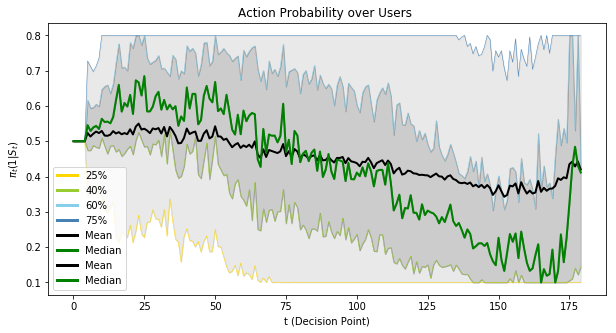

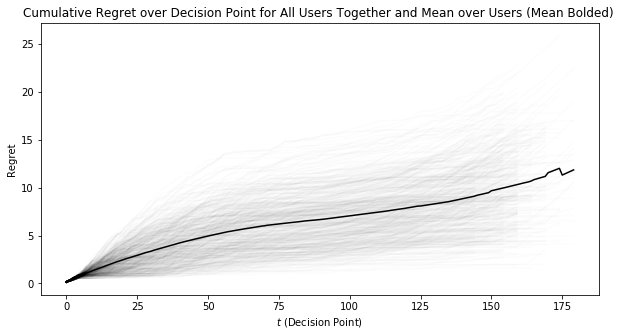

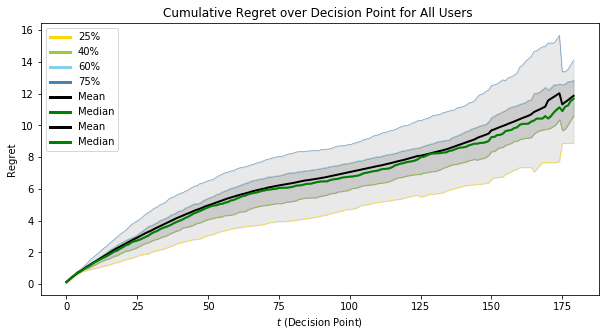

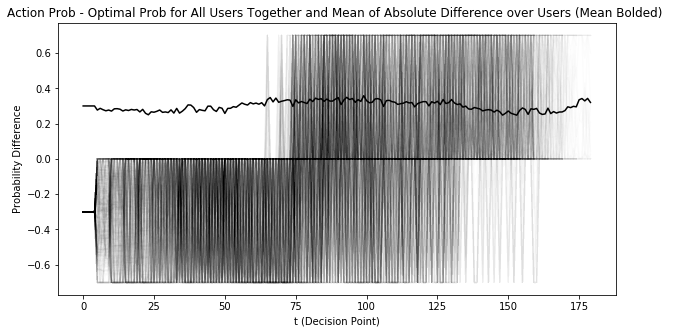

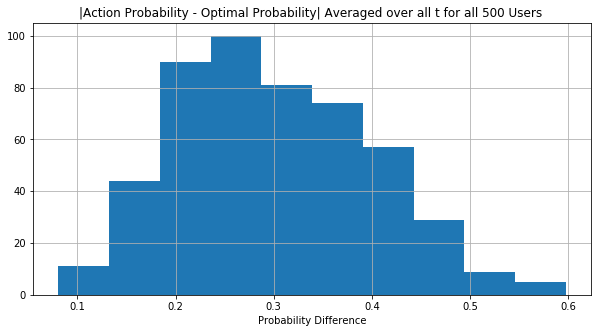

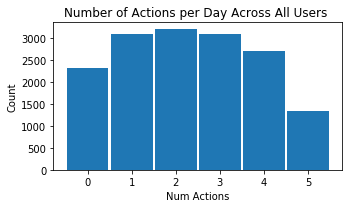

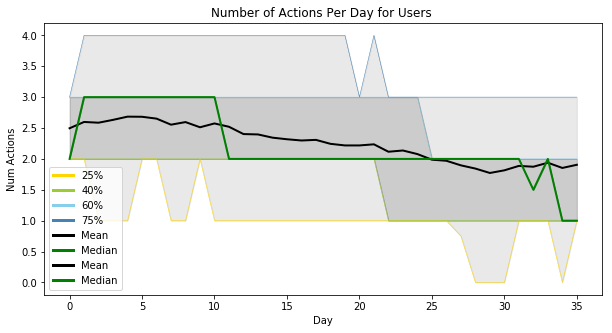

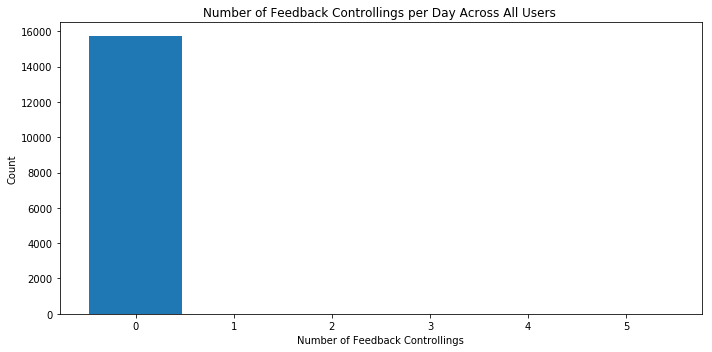

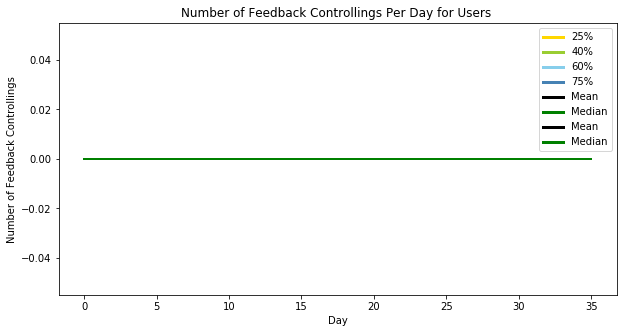

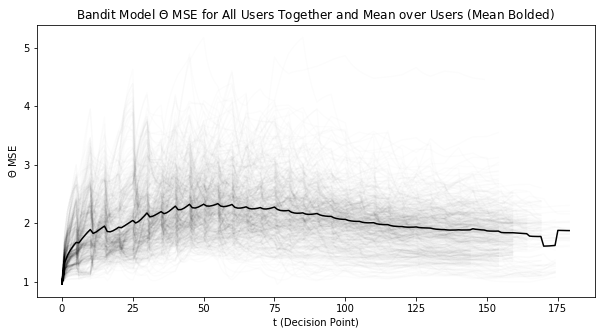

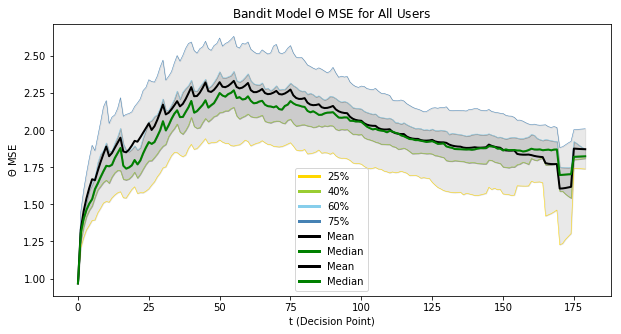

In [506]:
_ = plot_QM1(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM2(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM3(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM4(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM5(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM6(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM7(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM8(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM9(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM10(regret, prob, action, opt, fc_invoked, theta_mse)
_ = plot_QM11(regret, prob, action, opt, fc_invoked, theta_mse)

In [343]:
simNum = 4799
regret = np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/regret_simNum" + str(simNum) + ".npy")
prob = np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/prob_simNum" + str(simNum) + ".npy")
action = np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/action_simNum" + str(simNum) + ".npy")
opt = np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/opt_simNum" + str(simNum) + ".npy")
fc_invoked = np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/fc_invoked_simNum" + str(simNum) + ".npy")
theta_mse = np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/theta_mse_simNum" + str(simNum) + ".npy")

In [221]:
for sim_num in range(6):
    regret = np.load("C:/Users/isaac/Downloads/results_train11112/regret_simNum" + str(sim_num) + ".npy")

In [312]:
regret

array([[-0.3096419 , -0.44694681, -0.48494254, ...,         nan,
                nan,         nan],
       [-0.19291807, -0.25023353, -0.53243561, ...,         nan,
                nan,         nan],
       [-0.3896206 , -0.72581954, -0.32926011, ...,         nan,
                nan,         nan],
       ..., 
       [-0.19291807, -0.25023353, -0.53243561, ...,         nan,
                nan,         nan],
       [-0.24796735, -0.40310156, -0.28472964, ...,         nan,
                nan,         nan],
       [-0.6029349 ,  0.0959417 , -0.39458578, ...,         nan,
                nan,         nan]])

In [313]:
regret.shape

(500, 210)

In [226]:
np.nanmean(regret,axis=1)[0]

-0.13829685869966635

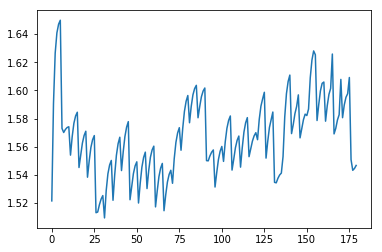

In [216]:
pd.DataFrame(theta_mse.T).mean(axis=1).plot()

In [208]:
rew

array([-0.6029349 ,  0.0959417 , -0.39458578,  0.08928495, -0.63127856,
        0.0741787 , -0.68724525, -0.37462806, -0.39033645,  0.07240679,
        0.07180896,  0.07244344,  0.07609591,  0.07355523,  0.07128365,
       -0.56644179, -0.62687142,  0.07149769, -0.41379126,  0.07898909,
        0.08122631, -0.47342457,  0.09282074, -0.50939486, -0.58131209,
        0.09209089,  0.07466743,  0.07724601,  0.07995064, -0.5493391 ,
       -0.54415449, -0.27721099, -0.51045821,  0.07396692, -0.54985004,
        0.07781286, -0.29973259,  0.07543038,  0.09583378, -0.24532654,
        0.08130021,  0.1131966 , -0.63521284,  0.08919869,  0.0845325 ,
       -0.49015605, -0.45523928, -0.63284759,  0.08282613,  0.12750644,
       -0.53019871, -0.37017674,  0.16024485,  0.11293189,  0.1637473 ,
        0.12563702, -0.52099944,  0.09927085, -0.22665662, -0.3952046 ,
        0.07915429, -0.54377892, -0.37332238, -0.61884209, -0.41535644,
       -0.45265579, -0.55988305,  0.1523688 , -0.22174948, -0.63

In [233]:
np.random.randn?

In [243]:
pd.DataFrame(regret.T).iloc[0,5].tolist()

0.09466323053093506

In [ ]:
pd

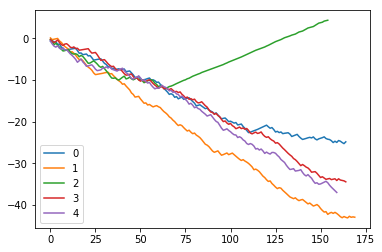

In [196]:
pd.DataFrame(regret.cumsum(axis=1).T).iloc[:,0:5].plot()

In [199]:
regret[2]

array([-0.28261998, -0.46516465, -0.77770871,  0.34839059, -0.43056475,
       -0.53505827, -0.4355283 , -0.45871472,  0.08254541,  0.19685377,
        0.07130247, -0.58476295, -0.40242022, -0.10667707,  0.07324642,
       -0.18241614, -0.53279104,  0.33159883, -0.2583826 , -0.51180431,
       -0.57447558, -0.56643143,  0.07110348,  0.26657987,  0.25945799,
       -0.35003515, -0.41532404, -0.51244364, -0.28060836,  0.22305771,
       -0.52587439, -0.53247192, -0.52820718, -0.63927204, -0.55681827,
       -0.07002479,  0.1079179 , -0.3643995 , -0.1708801 ,  0.32968844,
        0.33389398,  0.27712753, -0.66685856,  0.14333174,  0.27892759,
       -0.38635392, -0.2575494 ,  0.23272196,  0.28188258, -0.5217525 ,
        0.2444641 , -0.48044448, -0.44062798,  0.2538594 ,  0.22420975,
        0.10324184,  0.13288945, -0.26279021, -0.55722338, -0.32807373,
       -0.52398538,  0.23409332, -0.25854086, -0.25901378, -0.20755788,
        0.27884567,  0.24329604,  0.10724329,  0.17071358,  0.21

In [191]:
regret[0].cumsum()

array([ -0.6029349 ,  -0.5069932 ,  -0.90157898,  -0.81229403,
        -1.44357259,  -1.36939389,  -2.05663914,  -2.4312672 ,
        -2.82160366,  -2.74919687,  -2.67738791,  -2.60494448,
        -2.52884856,  -2.45529333,  -2.38400968,  -2.95045147,
        -3.57732289,  -3.5058252 ,  -3.91961646,  -3.84062737,
        -3.75940107,  -4.23282564,  -4.1400049 ,  -4.64939976,
        -5.23071185,  -5.13862097,  -5.06395353,  -4.98670753,
        -4.90675688,  -5.45609599,  -6.00025048,  -6.27746147,
        -6.78791969,  -6.71395277,  -7.2638028 ,  -7.18598995,
        -7.48572254,  -7.41029216,  -7.31445837,  -7.55978491,
        -7.4784847 ,  -7.3652881 ,  -8.00050094,  -7.91130225,
        -7.82676975,  -8.3169258 ,  -8.77216508,  -9.40501267,
        -9.32218654,  -9.1946801 ,  -9.72487882, -10.09505555,
        -9.9348107 ,  -9.82187881,  -9.65813152,  -9.5324945 ,
       -10.05349394,  -9.95422309, -10.18087971, -10.57608431,
       -10.49693002, -11.04070894, -11.41403132, -12.03

In [195]:
[0]

array([ -0.6029349 ,  -0.5069932 ,  -0.90157898,  -0.81229403,
        -1.44357259,  -1.36939389,  -2.05663914,  -2.4312672 ,
        -2.82160366,  -2.74919687,  -2.67738791,  -2.60494448,
        -2.52884856,  -2.45529333,  -2.38400968,  -2.95045147,
        -3.57732289,  -3.5058252 ,  -3.91961646,  -3.84062737,
        -3.75940107,  -4.23282564,  -4.1400049 ,  -4.64939976,
        -5.23071185,  -5.13862097,  -5.06395353,  -4.98670753,
        -4.90675688,  -5.45609599,  -6.00025048,  -6.27746147,
        -6.78791969,  -6.71395277,  -7.2638028 ,  -7.18598995,
        -7.48572254,  -7.41029216,  -7.31445837,  -7.55978491,
        -7.4784847 ,  -7.3652881 ,  -8.00050094,  -7.91130225,
        -7.82676975,  -8.3169258 ,  -8.77216508,  -9.40501267,
        -9.32218654,  -9.1946801 ,  -9.72487882, -10.09505555,
        -9.9348107 ,  -9.82187881,  -9.65813152,  -9.5324945 ,
       -10.05349394,  -9.95422309, -10.18087971, -10.57608431,
       -10.49693002, -11.04070894, -11.41403132, -12.03

In [ ]:
sim_param_vals.f

In [135]:

sim_param_vals = pd.DataFrame(np.empty((core_count * len(params) * num_run_through, len(params)+2)),columns=params + ["Mean","Std"])
# sim_param_vals.fill(np.nan)

In [136]:
sim_param_vals.i

,N_c_mult,T_c,sig2_mult,gamma,lamb,prior_cov_mult,Mean,Std
0,0.000000e+00,8.105121e-315,2.823585e-320,NaN,1.121529e-321,1.629693e-311,5.885147e-307,5.833298e-302
1,2.485627e-297,5.832902e-302,6.999569e-283,9.878204e-278,1.971091e-268,3.564562e-306,1.303165e-258,8.560405e-254
2,8.183229e-201,3.632251e-249,8.540430e+151,5.267504e+170,5.834395e+252,8.184330e-85,4.521812e+217,6.240142e-85
3,6.202040e+223,7.874881e+276,2.652926e+180,5.043425e+180,4.360383e+251,3.128566e+180,-9.785451e+197,2.165200e-256
4,5.992670e+175,2.649310e+180,1.137527e+243,6.151189e+72,1.219469e+199,2.164512e+233,3.018741e-321,1.086462e-311
5,2.720066e-307,2.217178e-301,3.561780e-306,2.581611e-306,5.340514e-306,5.795298e-85,2.100532e-301,5.340514e-306
6,7.747500e-297,8.902917e-307,1.930125e-309,2.781342e-309,4.227640e-307,1.392346e+188,6.260633e+250,2.361321e+236
7,-3.630026e+125,6.362952e-295,1.035653e-308,-4.538016e+279,5.831025e+252,9.701583e+189,1.436220e+161,4.963612e+247
8,1.169078e+171,9.302819e+242,1.828129e-19,3.655883e+233,3.406058e-309,4.702992e+170,6.354179e+151,4.824089e+228
9,1.170758e+214,8.894926e+252,4.566638e+44,1.021899e-152,4.824089e+228,1.494902e+248,1.286255e+248,2.456526e+198


In [114]:
sim_param_vals

,N_c_mult,T_c,sig2_mult,gamma,lamb,prior_cov_mult,Mean,Std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
import pandas as pd

In [ ]:
sim_param_vals = pd.DataFrame()

In [106]:
regret = np.load("../../Results/ST/reward_exp_simNum" + str(sim_num_done) + ".npy")
np.nanmean(regret,axis=1).std()


0.76696457194930912

In [111]:

sim_param_vals = pd.DataFrame(np.empty((core_count * len(params) * num_run_through, len(params)+2)),columns=params + ["Mean","Std"])

,N_c_mult,T_c,sig2_mult,gamma,lamb,prior_cov_mult,Mean,Std
0,4.940656e-324,8.105395e-315,2.786036e-320,NaN,4.589877e-311,0.000000e+00,5.328171e+233,3.865989e+233
1,7.872660e+276,9.750238e+199,9.669552e+242,1.943020e+227,5.292743e+199,1.876806e-152,1.237808e-259,4.824089e+228
2,3.526839e+233,1.275872e-152,7.266066e+223,9.073135e+223,9.477512e+170,8.879024e+73,1.792381e-19,2.420724e+232
3,8.963826e+276,2.053355e+190,9.514039e-90,2.875079e+161,6.942939e+193,1.234625e-259,4.909228e+252,4.475938e-91
4,3.475830e+183,4.002475e+151,2.904691e+180,1.382397e-94,1.171231e+166,1.255480e+232,3.933798e-85,1.335206e+228
5,1.459127e-152,1.951348e+227,1.106400e+200,1.507544e+161,1.488903e+195,7.102365e+194,5.292727e+199,1.375626e+214
6,2.168408e+243,2.439005e-154,3.582512e+246,3.624800e+228,7.203547e+159,7.776691e+160,4.224645e-153,2.314616e-152
7,1.276415e-152,5.069241e+252,7.105410e+159,8.564860e+183,1.668280e+243,4.202689e+88,4.572363e+228,8.928922e+271
8,1.133376e-153,8.903854e+252,1.021833e-152,5.292768e+199,5.630967e+175,1.275872e-152,2.057511e-81,1.098008e+248
9,4.497457e+251,3.446189e-85,8.177295e+173,5.852419e+199,1.276164e-152,1.505982e+161,2.612614e+257,5.037346e+180


[0.5, 5, 1.0, 0.9, 1.0, 10.0]

In [83]:
sim_param_vals[0]

array([  0.5,   5. ,   1. ,   0.9,   1. ,  10. ])

In [53]:
np.linspace(0.05,0.9,num=sim_count)

array([ 0.05  ,  0.2625,  0.475 ,  0.6875,  0.9   ])

In [28]:
param_vals

{'N_c_mult': 0.5,
 'T_c': 5,
 'gamma': 0.9,
 'lamb': 1.0,
 'prior_cov_mult': 0.5,
 'sig2_mult': 1.0}

In [38]:
with open("../Testing Scripts/yamls/params0.yaml") as f:
    a =  yaml.load(f)

In [ ]:
"../Testing Scripts/"

In [26]:
np.linspace(min_param_vals[param], max_param_vals[param],num=sim_count).round()

array([  0.,   3.,   5.,   8.,  10.])

In [ ]:
yaml.read

array([ 0.        ,  0.26315789,  0.52631579,  0.78947368,  1.05263158,
        1.31578947,  1.57894737,  1.84210526,  2.10526316,  2.36842105,
        2.63157895,  2.89473684,  3.15789474,  3.42105263,  3.68421053,
        3.94736842,  4.21052632,  4.47368421,  4.73684211,  5.        ])

{'N_c_mult': 0.5,
 'T_c': 5,
 'gamma': 0.9,
 'lamb': 1.0,
 'prior_cov_mult': 0.5,
 'sig2_mult': 1.0}

NameError: name 'pd' is not defined

In [87]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm


#################
# Test Bed 2-25 #
#################
# HS Analysis Functions

### Aux Functions for reading two different .csv files ###
def read_hs1(yoozer, hs1_file = "../../../Data/suggest-analysis-kristjan.csv"):
    pd_df = pd.read_csv(hs1_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)
    
    
    return ddf,pd_df

def read_hs1_gf(yoozer, hs1_gf_file = '../../../Data/suggest-kristjan.csv'):
    pd_df = pd.read_csv(hs1_gf_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)

    return ddf,pd_df


def nan_equal(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()


def standardize_column(ddf, col_name):
    '''Standardizes column col_name in ddf inplace, converting to a float too'''
    ddf.loc[:,col_name] = ddf[col_name].astype(float)
    ddf.loc[:,col_name] = (ddf[col_name] - ddf[col_name].mean()) / ddf[col_name].std()


def read_data_slow(N, T, t, nBaseline, data_loc_pref = "C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Data/"):
    ### Read in Feature vector, Reward Vector, and Action Vector for each user ###
    # Also Standardizes all features

    max_yoozer = N+1

    featVec = np.empty((max_yoozer,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((max_yoozer,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((max_yoozer,T*t))
    actionVec.fill(np.nan)

    for yoozer in range(1,max_yoozer):

        ddf,pd_df = read_hs1(yoozer, data_loc_pref + "suggest-analysis-kristjan.csv")
        #Make features
        
        #Center and scale
        decision_ind = ddf['decision.index.nogap']
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']

        assert np.all(send_any == send_active)

        # Study day index
        dazze = ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = ddf['study.day.nogap'].astype(float)
        day_ind = (day_ind - np.mean(day_ind))/np.std(day_ind)

        # Ohter location indicator
        loc_ind = ddf['loc.is.other'].astype(float)
        loc_ind = (loc_ind - np.mean(loc_ind))/np.std(loc_ind)

        # Std deviation of step count in last 7 days
        steps_sd = ddf['window7.steps60.sd'].astype(float)
        steps_sd = (steps_sd - np.mean(steps_sd))/np.std(steps_sd)

        # Step count in previous 30 minutes
        state = ddf['jbsteps30pre.log'].astype(float)
        state = (state - np.mean(state))/np.std(state)
        
        # Work location indicator
        wrk_ind = ddf['loc.is.work'].astype(float) #compare to string “work”
        wrk_ind = (wrk_ind - np.mean(wrk_ind))/np.std(wrk_ind)

        # Square root steps yesterday
        steps_yest = ddf['steps.yesterday.sqrt'].astype(float)
        steps_yest = (steps_yest - np.mean(steps_yest))/np.std(steps_yest)

        # Temperature, set -1024 as 0
        temp = ddf['temperature'].astype(float)
        temp[ddf['temperature'] == -1024] = 0
        temp = (temp - np.mean(temp))/np.std(temp)
        

        ddfgf,pd_dfgf = read_hs1_gf(yoozer, data_loc_pref + "suggest-kristjan.csv")


        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[yoozer,:end_ind] = reward_h.astype(float)
        actionVec[yoozer,:end_ind] = send_any.astype(float)

        featVec[yoozer,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[yoozer,:end_ind,1] = day_ind #study.day.nogap
        featVec[yoozer,:end_ind,2] = loc_ind # loc.is.other
        featVec[yoozer,:end_ind,3] = steps_sd # window7.steps60.sd
        featVec[yoozer,:end_ind,4] = state # jbsteps30pre.log
        featVec[yoozer,:end_ind,5] = wrk_ind # loc.is.work
        featVec[yoozer,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[yoozer,:end_ind,7] = temp # temperature

    
    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    
    # Drop users with no data
    rewardVec = rewardVec[~np.isnan(featVec).all(axis=(1,2))]
    actionVec = actionVec[~np.isnan(featVec).all(axis=(1,2))]
    featVec = featVec[~np.isnan(featVec).all(axis=(1,2))]
    
    return featVec, rewardVec, actionVec


def read_data(N, T, t, nBaseline, data_loc_pref):

    ddf = pd.read_csv(data_loc_pref + "suggest-analysis-kristjan.csv")
    # Filter for when either sent active message or no message at all, and relevant columns
    ddf = ddf.loc[(ddf["send.active"] == 1) | (ddf["send"] == 0),["user","study.day.nogap","loc.is.other","window7.steps60.sd","jbsteps30pre.log","loc.is.work","steps.yesterday.sqrt","temperature","send","send.active","jbsteps30.log"]]

    # Standardize columns
    standardize_column(ddf,"study.day.nogap")
    standardize_column(ddf,"loc.is.other")
    standardize_column(ddf,"window7.steps60.sd")
    standardize_column(ddf,"jbsteps30pre.log")
    standardize_column(ddf,"loc.is.work")
    standardize_column(ddf,"steps.yesterday.sqrt")
    ddf.loc[ddf["temperature"] == -1024,"temperature"] = np.nan # replace bad temperature measurement with null
    standardize_column(ddf,"temperature")
    ddf.loc[ddf["temperature"].isnull(),"temperature"] = ddf["temperature"].mean()


    featVec = np.empty((N+1,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((N+1,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((N+1,T*t))
    actionVec.fill(np.nan)

    for user in range(1,N+1):
        user_ddf = ddf[ddf["user"] == user]
        #Center and scale
        reward_h = user_ddf['jbsteps30.log']
        send_any = user_ddf['send']
        send_active = user_ddf['send.active']

        assert np.all(send_any == send_active)

        # Study day index
        dazze = user_ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = user_ddf['study.day.nogap']

        # Other location indicator
        loc_ind = user_ddf['loc.is.other']

        # Std deviation of step count in last 7 days
        steps_sd = user_ddf['window7.steps60.sd']

        # Step count in previous 30 minutes
        state = user_ddf['jbsteps30pre.log']

        # Work location indicator
        wrk_ind = user_ddf['loc.is.work']

        # Square root steps yesterday
        steps_yest = user_ddf['steps.yesterday.sqrt']

        # Temperature, set -1024 as 0
        temp = user_ddf['temperature']



        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[user,:end_ind] = reward_h.astype(float)
        actionVec[user,:end_ind] = send_any.astype(float)

        featVec[user,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[user,:end_ind,1] = day_ind #study.day.nogap
        featVec[user,:end_ind,2] = loc_ind # loc.is.other
        featVec[user,:end_ind,3] = steps_sd # window7.steps60.sd
        featVec[user,:end_ind,4] = state # jbsteps30pre.log
        featVec[user,:end_ind,5] = wrk_ind # loc.is.work
        featVec[user,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[user,:end_ind,7] = temp # temperature

    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    
    # Drop users with no data
    rewardVec = rewardVec[~np.isnan(featVec).all(axis=(1,2))]
    actionVec = actionVec[~np.isnan(featVec).all(axis=(1,2))]
    featVec = featVec[~np.isnan(featVec).all(axis=(1,2))]
    
    return featVec, rewardVec, actionVec

def resid_regression(N, T, t, nBaseline, nInteract, f_baseline, f_interact, rewardVec, actionVec, featVec):
    '''Perform Regression on Pooled R ~ A*S' + S to create Residuals'''
    # Actual Dimensions of A and S
    a_dim = 1
    s_dim = nBaseline

    # Copy for notational ease
    R = rewardVec.copy()
    A = actionVec.copy()
    S = featVec.copy()


    # Fit OLS r ~ (a_t s'_t, s_t)^T \eta, where s' are interact terms and s are all baseline
    
    exog = np.concatenate([(A * f_interact(S)), f_baseline(S)], 2).reshape((N*T*t,(nInteract + nBaseline)))
    resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = exog, missing = "drop")
    resids_unproc = resid_model.fit().resid

    # Parameters
    Thetas_fit = resid_model.fit().params


    ## Fill resids ##

    # Copy shape and location of nans
    resids = rewardVec.copy()

    curr_ind = 0
    for n in range(N):

        old_ind = curr_ind
        curr_ind += R[n][~np.isnan(R[n])].shape[0]

        # Copy in indices
        resids[n][:curr_ind-old_ind] = resids_unproc[old_ind:curr_ind]
    
    return resids, Thetas_fit, resid_model


# # Code to Generate Simulated Users USE IF WANT CUSTOM LENGTH TIME
def generate_new_users(resids, A, S, N_new, T_new, T, t, users_to_sample = 10):
    '''
    Generates new random user, with variable time T_new
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of new users to generate from sampling
        T_new: Int of number of days for each new user
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.empty((N_new, users_to_sample)).astype(int)

    # Loop to reset sampling without replacement for each new user
    for i in range(N_new):
        sampled_user_indices[i] = np.random.choice(N, size = users_to_sample, replace = False)
    
    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users_untreated = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, users_to_sample * T*t, 1 + a_dim + s_dim)
    sampled_users = np.empty((N_new, T_new * t, 1 + a_dim + s_dim))
    
    for i in range(N_new):
        
        # Cast to DataFrame to dropna, reset index to shift datapoints up to be consecutive, takes T_new * t datapoints
        sampled_users[i] = pd.DataFrame(sampled_users_untreated[i]).apply(lambda col: col.dropna().reset_index().iloc[:,-1], axis = 0).as_matrix()[:T_new * t]
        
    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T_new, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T_new, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T_new, t, s_dim)
    
    return resids_new, A_new, S_new


# # Code to Generate Simulated Users
def sample_sim_users(resids, A, S, N_new, T, t, seed = None):
    '''
    Generates new random users by sampling from the population
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of users to generate from sampling
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.random.RandomState(seed).choice(N, size = N_new, replace = True)

    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, T * t, 1 + a_dim + s_dim) # resids_dim + actions_dim + states_dim

    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T, t, s_dim)
    
    return resids_new, A_new, S_new




# #Create a reward function from true coefficients, with residuals non-mandatory
# def reward_func_identity(S, A, coef0, coef1, resid = None, single_dim = True):
#     '''Basic reward function, can edit for different generative models.
#     Identity on baseline and interaction terms.
#     Works for multidimensional eta, a, and s, so long as they are of same multidimension.
#     Assumes s has first element as bias for the regression.
    
#     Resid must be passed in if not single dim.
#     If single dim, can speed out without np.take.'''
    
#     nInteract = len(coef1)
    
#     if single_dim:
#         predictors = np.concatenate([A * S[1:1+nInteract], S], 0)
#     else:
#         predictors = np.concatenate([A * np.take(S,range(1,1+nInteract),-1), S], 0)
    
#     Theta = np.concatenate([coef1, coef0])
    
#     if resid is None:
#         resid = 0
        
#     return(resid + np.dot(predictors, Theta))


# #Create a reward function from true coefficients, with residuals non-mandatory
# def reward_func_small(S, A, coef0, coef1, resid = None, single_dim = True):
#     '''Basic reward function, can edit for different generative models.
#     Identity on baseline and interaction terms.
#     Works for multidimensional eta, a, and s, so long as they are of same multidimension.
#     Assumes s has first element as bias for the regression.
    
#     Resid must be passed in if not single dim.
#     If single dim, can speed out without np.take.'''
    
#     nInteract = len(coef1)
    
#     if single_dim:
#         predictors = np.concatenate([A * S[1:1+nInteract], S], 0)
#     else:
#         predictors = np.concatenate([A * np.take(S,range(1,1+nInteract),-1), S], 0)
    
#     Theta = np.concatenate([coef1, coef0])
    
#     if resid is None:
#         resid = 0
        
#     return(resid + np.dot(predictors, Theta))



#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func_general(S, A, coef0, coef1, f_baseline, f_interact, resid = None):
    '''Generalized reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    
    predictors = np.concatenate([A * f_interact(S), f_baseline(S)], -1)
    
    Theta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Theta))


def k_fold_split(S, R, A, k = 5, seed = None):
    '''
    Split S,R,A into k fold train/test batches of roughly size N/k
    seed: random seed
    '''
    combined = np.copy(np.concatenate([S,np.expand_dims(R,-1),A],axis=-1))

    np.random.RandomState(seed).shuffle(combined) # Shuffle all together
    N = combined.shape[0]

    tests = []
    trains = []
    
    for i in range(k):
        # For each N/k sized batch, return test and train
        tests.append(combined[int(i*(N/k)):int((i+1)*(N/k))])
        trains.append(np.concatenate([combined[:int(i*(N/k))], combined[int((i+1)*(N/k)):]]))
    
    train_zip = []
    test_zip = []
    
    # Separate back to (S,R,A)
    for train in trains:
        train_zip.append((train[:,:,:S.shape[-1]], train[:,:,S.shape[-1]:1+S.shape[-1]], train[:,:,S.shape[-1]+1:]))
    for test in tests:
        test_zip.append((test[:,:,:S.shape[-1]], test[:,:,S.shape[-1]:1+S.shape[-1]], test[:,:,S.shape[-1]+1:]))
        
    return train_zip, test_zip


########################################################################################
#THE BANDIT CODE (in class form)
##### A bandit model, consisting of reward coefficient mean and covariance

# From Peng's 2-1 algorithm; action-centered bandit (algorithm 2)


class model:
    def __init__(self,mu,Sigma):
        self.mu = mu
        self.Sigma = Sigma
        

#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self, nInteract, prior_model, gamma, f_baseline, f_interact, fc_params = None, pc_params = None, sigma2 = 1., prior_weight = 1., fc_flag = True, pc_flag = True, ac_flag = True):
        '''
        pc_params: (pi_min, pi_max) parameters for probability clipping
        prior_model: prior Gaussian model with \mu_\beta, \Sigma_\beta
        gamma: gamma for GP Prior
        fc_params: feedback controller parameters: (\lambda_c, N_c, T_c)
            T_c: maximum number of decision times to count dosage
        f_baseline: baseline feature mapping; f: S \to R^p_1
        f_interact: interaction feature mapping; f_interact: S' \to R^p_2
        sigma2: reward noise estimate (variance)
        prior_weight: how much to weigh prior, set to 1 for full weight

        fc_flag, pc_flag, ac_flag: Whether bandit should include feedback controller, probability clipping, or action centering; True is include, False is not include
        '''
        
        #initialize input parameters


        self.fc_flag = fc_flag
        self.pc_flag = pc_flag
        self.ac_flag = ac_flag


        self.nInteract = nInteract
        if pc_flag:
            self.pi_min = pc_params[0]
            self.pi_max = pc_params[1]
        self.gamma = gamma
        self.sigma2 = sigma2

        self.f_baseline = f_baseline
        self.f_interact = f_interact

        if fc_flag:
            self.lambda_c = fc_params[0]
            self.N_c = fc_params[1]
            self.T_c = int(fc_params[2])


        
        #Initialize model to prior data model
        # Mean = prior_weight * prior_model.mu,
        # Cov = I_n + prior_weight * prior_model.Sigma
        
        self.prior_model = prior_model

        # This is mu and Sigma
        self.current_model = model(prior_weight*prior_model.mu,
            (1-prior_weight)*np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        # This is mu' and Sigma'
        self.daystart_model = model(prior_weight*prior_model.mu,
            (1-prior_weight)*np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        
    def process_context(self, I_T, S_T, N_t = None):
        '''
        Inputs context for a given decision point,
        updates the current day's model, and returns action probability alpha

        Line 20 of algorithm

        I_T: Current availability
        S_T: Current state
        N_t: Dosage over past T_c decision times; number of messages sent since present minus T_c
        Returns: alpha, probability of taking action 1
        '''
        if I_T == 1:
            current_model = self.current_model
            # Current Posterior mean and variance for interaction term
            mu2 = current_model.mu[:self.nInteract]
            Sigma2 = current_model.Sigma[:self.nInteract,:self.nInteract]

            # Compute probability of unclipped randomization probability
            X_mean = self.f_interact(S_T).T.dot(mu2)

            if self.fc_flag: # If using feedback controller, subtract fc term
                X_mean = self.f_interact(S_T).T.dot(mu2) - self.lambda_c*(N_t - self.N_c)*(N_t - self.N_c > 0)
            X_var = self.f_interact(S_T).dot(Sigma2.dot(self.f_interact(S_T).T))

            # Actual probability
            pi_t = 1 - norm.cdf(0, X_mean, np.sqrt(X_var))

            alpha = pi_t

            if self.pc_flag:
                if pi_t < self.pi_min:
                    alpha = self.pi_min
                elif pi_t > self.pi_max:
                    alpha = self.pi_max

        
        else:
            alpha = 0

        # Update current model to posterior of Gaussian Process
        self.current_model.mu = (1-self.gamma)*self.prior_model.mu + self.gamma * self.current_model.mu
        self.current_model.Sigma = (1 - self.gamma ** 2.) * self.prior_model.Sigma + (self.gamma ** 2.) * self.current_model.Sigma 

        return alpha #probability of taking action 1

        
    ######
    
    def update_model_daily(self, S_T, R_T, A_T, pi_T, I_T, t = 5):
        # Update at end of day
        '''
        At end of day, updates the 
        S_T: states for day T
        R_T: rewards for day T
        A_T: actions for day T
        pi_T: probabilities of action 1 for day T
        I_T: availability for each time point on day T
        t: number of decision points per day, defaults to 5
        '''

        # Set aliases for the current model
        current_model = self.current_model
        current_model.mu = self.daystart_model.mu
        current_model.Sigma = self.daystart_model.Sigma

        for dpt in range(t):
            # If available then:
            if I_T[dpt]:
                if self.ac_flag:
                    f_t = np.concatenate([(A_T[dpt] - pi_T[dpt]) * self.f_interact(S_T[dpt]), self.f_baseline(S_T[dpt])], axis=0)
                else:
                    f_t = np.concatenate([(A_T[dpt]) * self.f_interact(S_T[dpt]), self.f_baseline(S_T[dpt])], axis=0)
            
                Sigma_dot_f_t = np.expand_dims(current_model.Sigma.dot(f_t),1)
                denom = self.sigma2 + f_t.T.dot(Sigma_dot_f_t)
                beta = current_model.mu + (R_T[dpt] - f_t.T.dot(current_model.mu)) / denom * Sigma_dot_f_t
                Omega = current_model.Sigma - 1. / denom * Sigma_dot_f_t.dot(Sigma_dot_f_t.T)
                current_model.mu = self.gamma * beta           + (1 - self.gamma) * self.prior_model.mu
                current_model.Sigma = (self.gamma ** 2.) * Omega + (1 - self.gamma ** 2.) * self.prior_model.Sigma
        
        # New day, new model

        self.daystart_model.mu = current_model.mu.copy()
        self.daystart_model.Sigma = current_model.Sigma.copy()
        
########

#####################################################################
#A simulation of above standard model.

#A simulation of above standard model.


def run_simulation(coef0, coef1, S_sim, I_sim, resids_sim, reward_func, prior_model,f_baseline, f_interact,f_baseline_identity, f_interact_identity,
                   fc_params = None, nInteract = 3+1, nBaseline = 7+1, pc_params = [.1, .8],
                   gamma = 1., sigma2 = 1. , T = 42, t = 5, no_resid_flag = False,
                   seed = None, fc_flag = True, pc_flag = True, ac_flag = True, Thetas_fit_bandit = None):
    '''
    coef0: Reward coefficients for baseline, first element is bias term
    coef1: Reward coefficients for interaction, first element is bias term; note that concatenated, [coef1, coef0] = Theta
    S_sim: simulated states
    I_sim: simulated availabilities; 1 = available, 0 = unavailable
    resids_sim: Residuals of simulated users
    reward_func: reward function of "True" Generative Model, must have type reward(featVec, action, coef0, coef1, resid)
    nInteract: Number of interaction features in Bandit Model
    nBaseline: Number of baseline features in Bandit Model
    pc_params: Bandit probability clipping parameters; [minprob, maxprob, priorweight]
    f_baseline: Creates baseline features from state in Bandit Model
    T: days of study
    t: decision points per day
    no_resid_flag: If True will substitute 0 for residuals, if False will use true residuals

    fc_flag, pc_flag, ac_flag: Whether bandit should include feedback controller, probability clipping, or action centering; True is include, False is not include
    '''
    N = S_sim.shape[0]
    assert T == S_sim.shape[1]
    assert t == S_sim.shape[2]
    
    #creating variables for saving history of what we do
    # reward_exp = np.empty((N, T, t)) # Bandit reward
    regret = np.empty((N, T, t))
    prob  = np.empty((N, T, t))
    action = np.empty((N, T, t))
    opt = np.empty((N, T, t))
    fc_invoked = np.empty((N, T, t))
    regret.fill(np.nan)
    prob.fill(np.nan)
    action.fill(np.nan)
    opt.fill(np.nan)
    fc_invoked.fill(np.nan)
    
    seed_rand = np.random.RandomState(seed)
    
    # Containers for bandit parameters
    #bandit_covs = np.empty((N, T,t, nInteract+nBaseline, nInteract+nBaseline))
    #bandit_covs.fill(np.nan)
    theta_mse = np.empty((N, T,t))
    theta_mse.fill(np.nan)

    for sim_user_index in range(N):

        # Create and initialize bandit object for each user
        bandit = ContextBandit(nInteract = nInteract, prior_model = prior_model, gamma = gamma, f_baseline = f_baseline, f_interact = f_interact, sigma2 = sigma2, pc_params = pc_params, fc_params = fc_params, fc_flag = fc_flag, pc_flag = pc_flag, ac_flag = ac_flag)


        #Cycle through days where not all values are nan
        T_max = np.where(np.isnan(resids_sim[sim_user_index].sum(axis=1)))[0][0]
        
        for day in range(T_max):

            rwd = np.zeros(t)
            #Cycle thru decision points in each day
            for dpt in range(t):
                user_resid = resids_sim[sim_user_index, day, dpt]
                if no_resid_flag:
                    user_resid = 0
                    
                #Get action probability from bandit
                
                # featInteract = S_sim[sim_user_index, day, dpt, 1:1+nInteract] #only use the interaction features, but first element is bias
                if False: #Do nothing
                    prob[sim_user_index, day, dpt] = 0
                else: #Use bandit; invoke feedback controller if flag is on
                    if fc_flag:
                        # Count dosage from previous T_c decision points
                        N_t = np.sum(action[sim_user_index].reshape(-1)[max(0,-bandit.T_c + day*t + dpt):day*t + dpt])
                        # Compute clipped probability
                        prob[sim_user_index, day, dpt] = bandit.process_context(
                        I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt], N_t)
                        # Save whether feedback controller was used
                        fc_invoked[sim_user_index, day, dpt] = (N_t > bandit.N_c)
                    else:
                        prob[sim_user_index, day, dpt] = bandit.process_context(
                        I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt])


                #Choose action based on probability, i.e. do the randomization
                if seed_rand.rand() < prob[sim_user_index, day, dpt]:
                    action[sim_user_index, day, dpt] = 1
                else:
                    action[sim_user_index, day, dpt] = 0

                #Receive reward from the universe. 
                rwd[dpt] = reward_func(S_sim[sim_user_index, day, dpt], action[sim_user_index, day, dpt], coef0, coef1, f_baseline_identity, f_interact_identity, user_resid)

                #What was expected regret given probability chosen by bandit?
                #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
                rwd0 = reward_func(S_sim[sim_user_index, day, dpt], 0, coef0, coef1, f_baseline_identity, f_interact_identity, user_resid)
                rwd1 = reward_func(S_sim[sim_user_index, day, dpt], 1, coef0, coef1, f_baseline_identity, f_interact_identity, user_resid)

                #Expected reward under bandit policy
                rwdExp = prob[sim_user_index, day, dpt]*rwd1 + (1-prob[sim_user_index, day, dpt])*rwd0

                #Regret is difference between optimal reward and the reward we got
                regret[sim_user_index, day, dpt] = max(pc_params[0]*rwd1 + (1-pc_params[0])*rwd0, pc_params[1]*rwd1 + (1-pc_params[1])*rwd0) - rwdExp

                opt[sim_user_index, day, dpt] = pc_params[1] * (rwd1 > rwd0) + pc_params[0] * (rwd1 <= rwd0)

            #Perform bandit updates at end of day
            for dpt in range(t):
                #bandit_covs[sim_user_index, day, dpt] = bandit.daystart_model.Sigma
                theta_mse[sim_user_index, day, dpt] = ((Thetas_fit_bandit - bandit.daystart_model.mu) ** 2).mean()
                bandit.update_model_daily(S_sim[sim_user_index, day], rwd, action[sim_user_index, day], prob[sim_user_index, day], I_sim[sim_user_index, day])

    #return reward_exp.reshape((N,T*t)), reward_0.reshape((N,T*t)), reward_1.reshape((N,T*t)), prob.reshape((N,T*t)), action.reshape((N,T*t)), fc_invoked.reshape((N, T*t)), bandit_covs.reshape((N,T*t, nInteract+nBaseline,nInteract+nBaseline)), bandit_means.reshape((N,T*t, nInteract+nBaseline)), bandit
    return regret.reshape((N,T*t)), prob.reshape((N,T*t)), action.reshape((N,T*t)), opt.reshape((N, T*t)), fc_invoked.reshape((N, T*t)), theta_mse.reshape((N,T*t)), bandit



In [92]:
import datetime
from hs_test_funcs import *
import numpy as np
import datetime
import yaml
import os
import sys


'''
Read in:
'''
# python hs_test_runner.py <job_num> <out_dir> <data_loc_pref> <param_loc> <final_flag>
# assert len(sys.argv) >= 5
job_num = 0
# print(sys.argv)

out_dir = ""


data_loc_pref = "../../Data/"
param_loc = ""

final_flag = False





def f_baseline_small(featVec):
    return featVec[...,[0,3,4,5,6]]

def f_interact_small(featVec):
    return featVec[...,[0,1,2]]


def f_baseline_identity(featVec):
    return featVec

def f_interact_identity(featVec):
    return featVec[...,:4]

params = yaml.load('''N_c_mult: 0.2531446540880503
T_c: 65.0
ac_flag: true
batch_num: 1
computed: true
fc_flag: true
gamma: 1.0
k: 3
lamb: 0.1
pc_flag: true
prior_cov_mult: 1.358490566037736
prior_mean: [-0.011041496626134926, -0.26373134830871414, -0.327226041820894, 0.21238949046759267,
  3.1126972408493163, -0.05033383713046785, 0.12875012276685938, 0.17255786670615617,
  1.336849277538778, 0.12878364053008437, 0.24320045386907196, 0.05358289181512156]
resid_sig2: 7.177865432458138
sig2_mult: 1.352830188679245
sim_num: 20180331
sim_seed: 12731221
small_flag: false
split_seed: 461247612
train: false''')


In [93]:

locals().update(params)



# Generative Model fit


#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func_general(S, A, coef0, coef1, f_baseline, f_interact, resid = None):
    '''Generalized reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    
    predictors = np.concatenate([A * f_interact(S), f_baseline(S)], -1)
    
    Theta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Theta))



## Creating Simulations



# Counts from HS 1
N_data = 48 # users indexed up to 48, but true count is 37
N = 37
T = 42
t = 5
nFeatures = 1+7
nBaseline_identity = 1+7
nInteract_identity = 1+3 # Add 1 for bias term
nBaseline_small = 1+4
nInteract_small = 1+2 # Add 1 for bias term

N_sim = 25
T_new = 90

# start = datetime.datetime.now()

S, R, A = read_data(N_data, T, t, nFeatures, data_loc_pref)


##########################
## SET BANDIT MODEL ##
##########################
if small_flag:
    f_interact = f_interact_small
    f_baseline = f_baseline_small
    nInteract = nInteract_small
    nBaseline = nBaseline_small
else:
    f_interact = f_interact_identity
    f_baseline = f_baseline_identity
    nInteract = nInteract_identity
    nBaseline = nBaseline_identity




# ###############
# ## Non-split ##
# ###############
# resids, Thetas_fit, resid_model = resid_regression(N, T, t, nBaseline, nInteract, f_baseline_identity, f_interact_identity, R, A, S)
# resids_new, A_new, S_new = sample_sim_users(resids, A, S, N_sim, T, t)
# I_new = np.expand_dims(~np.isnan(S_new).any(axis=-1),-1).astype(int) #



# resid_sig2 = np.nanvar(resids)
# prior_mean = Thetas_fit



# prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
# fc_params = [lamb, int(N_c_mult*T_c), T_c]


# # sim_start = datetime.datetime.now()
# # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)
# reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)




In [94]:

##################################
## Split train and test batches ##
##################################
train_zip, test_zip = k_fold_split(S,R,A,k,seed = split_seed) ## Seed for split

if train:
    S_train,R_train,A_train = train_zip[batch_num]

else:
    S_train,R_train,A_train = test_zip[batch_num]


resids_train, Thetas_fit_train, resid_model_train = resid_regression(S_train.shape[0], T, t, nBaseline_identity, nInteract_identity, f_baseline_identity, f_interact_identity, R_train.squeeze(), A_train, S_train)
_, Thetas_fit_bandit_train, _ = resid_regression(S_train.shape[0], T, t, nBaseline, nInteract, f_baseline, f_interact, R_train.squeeze(), A_train, S_train)
# First Thetas_fit is for the true generative model, second is for the bandit model

resids_new_train, A_new_train, S_new_train = sample_sim_users(resids_train, A_train, S_train, N_sim, T, t, seed = split_seed)
I_new_train = np.expand_dims(~np.isnan(S_new_train).any(axis=-1),-1).astype(int) #

if train:
    resid_sig2 = np.nanvar(resids_train)
    prior_mean = np.zeros(nInteract+nBaseline)


prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
fc_params = [lamb, int(N_c_mult*T_c), T_c]


# sim_start = datetime.datetime.now()
# reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)

regret, prob, action, opt, fc_invoked, theta_mse, bandit = run_simulation(coef0 = Thetas_fit_train[nInteract_identity:nInteract_identity+nBaseline_identity], coef1 = Thetas_fit_train[0:nInteract_identity], nInteract = nInteract, nBaseline = nBaseline, S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline, f_interact=f_interact, f_baseline_identity=f_baseline_identity, f_interact_identity=f_interact_identity, reward_func = reward_func_general, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed, ac_flag = ac_flag, fc_flag = fc_flag, pc_flag = pc_flag, Thetas_fit_bandit = Thetas_fit_bandit_train)


In [96]:
regret[5]

array([-0.29997604, -0.58768164,  0.08239113,  0.08239113,  0.08955852,
        0.08559092,  0.10241122, -0.60395369,  0.10254303, -0.49255392,
       -0.71744487, -0.44511543, -0.41016949, -0.40689027, -0.59597158,
       -0.31272455, -0.55094998, -0.47699071, -0.1593061 , -0.36045771,
       -0.17699917, -0.59422818,  0.18409262, -0.40406757, -0.41554457,
       -0.36955006, -0.4908185 ,  0.10484841,  0.10381557, -0.64163826,
       -0.19140745, -0.41215256, -0.53520151,  0.12200934, -0.59555376,
       -0.64517486,  0.10385586, -0.26514016,  0.15303811, -0.35411392,
       -0.49967291,  0.09029774, -0.57388476, -0.61006366, -0.3908654 ,
       -0.46466333,  0.14851223,  0.17197767,  0.18876078,  0.07398988,
       -0.52448733,  0.16976527, -0.62839199, -0.46605506,  0.10454197,
        0.08289344, -0.60604792, -0.61327061, -0.5758281 , -0.25709924,
       -0.35860469, -0.51895594, -0.56329112, -0.39081238,  0.1075544 ,
       -0.49656143, -0.412959  , -0.48986923,  0.14638229,  0.16

C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


ValueError: max must be larger than min in range parameter.

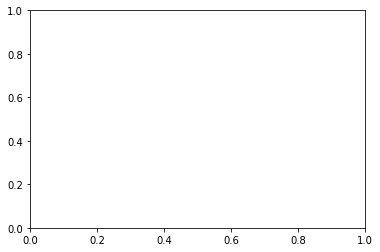

In [79]:
plt.hist(np.nanmean(prob,axis=0))

In [ ]:
b

#################
## Output Data ##
#################

# datNames = ["reward_exp","reward_0","reward_1","prob","action","fc_invoked","bandit_mean"]
# dats = [reward_exp,reward_0,reward_1,prob,action,fc_invoked,bandit_mean]

# Without bandit_mean
if not final_flag:
    datNames = ["regret","prob","action","opt","fc_invoked","theta_mse"]
    dats = [regret,prob,action,opt,fc_invoked,theta_mse]

    for dat, datName in zip(dats, datNames):
        np.save(out_dir + datName + "_simNum" + str(sim_num) + ".npy", dat)

# OPTIONAL
if final_flag:
    #################
    ## Save Params ##
    #################
    if train:
        params["computed"] = True
        params["prior_mean"] = Thetas_fit_bandit_train.tolist()
        params["resid_sig2"] = float(resid_sig2)
        params["train"] = False
        with open(param_loc + "/params" + str(job_num) + ".yaml", "w") as f:
            yaml.dump(params, f)
